# Primordial non-Gaussianity examples

In this notebook we will show how to perform PNG fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [6]:
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 61)
edges = np.column_stack([edges[:-1], edges[1:]])
k = np.mean(edges, axis=-1)
nmodes = 4. * np.pi / 3. * (edges[..., 1]**3 - edges[..., 0]**3)
z = 1.
fo = cosmo.get_fourier()
pk = fo.pk_interpolator(of='delta_cb')(k, z=z)
pk_prim = cosmo.get_primordial(mode='scalar').pk_interpolator()(k)
pphi_prim = 9 / 25 * 2 * np.pi**2 / k**3 * pk_prim / cosmo.h**3
alpha = 1. / (pk / pphi_prim)**0.5

fnl = 100.
# PNG response of dark matter halos in spherical collapse
b1 = 2.
bphi = 2. * 1.686 * (b1 - 1.)
b = b1 + bphi * fnl * alpha
f = fo.sigma8_z(z, of='theta_cb') / fo.sigma8_z(z, of='delta_cb')
shotnoise = np.ones_like(k) / 1e-4
volume = 1e9

ells = (0, 2)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles = np.array(poles, dtype='f8')

from lsstypes import Mesh2SpectrumPole, Mesh2SpectrumPoles
mean = [Mesh2SpectrumPole(k=k, k_edges=edges, num_raw=value, num_shotnoise=(ell == 0) * shotnoise, ell=ell) for ell, value in zip(ells, poles)]
mean = Mesh2SpectrumPoles(mean)

cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1000):
    tmp = mean.clone(value=rng.multivariate_normal(mean.value().ravel(), cov))
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

## PNG likelihood

In [8]:
from desilike.theories.galaxy_clustering import FixedPowerSpectrumTemplate, PNGTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.parameter import ParameterCollection
from desilike import setup_logging


template = FixedPowerSpectrumTemplate(z=z, fiducial='DESI')
# fnl_loc is degenerate with PNG bias bphi. Parameterization is controlled by "mode".
# - "b-p": bphi = 2 * 1.686 * (b1 - p), p as a parameter
# - "bphi": bphi as a parameter
# - "bfnl_loc": bfnl_loc = bphi * fnl_loc as a parameter'
# Here we choose b-p parameterization
theory = PNGTracerPowerSpectrumMultipoles(template=template, mode='b-p')
theory.init.params['p'].update(fixed=True)  # not fixing p biases fnl_loc posterior
# In our mock data sigmas = 0, so just fix it to 0
#theory.init.params['sigmas'].value = 0.
#theory.init.params['sigmas'].fixed = True
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=mocks,
                                                     #klim={0: [0.005, 0.2]},
                                                     klim={0: [0.005, 0.2, 0.005], 2: [0.005, 0.2, 0.005]}, # fit monopole and quadrupole, between 0.005 and 0.2 h/Mpc
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

setup_logging()
likelihood()  # just to initialize

[000001.92] [0/1] 11-28 05:54  ObservablesGaussianLikelihood INFO     Covariance matrix with 78 points built from 999 observations.
[000001.92] [0/1] 11-28 05:54  ObservablesGaussianLikelihood INFO     ...resulting in a Hartlap 2007 factor of 0.9208.
[000001.93] [0/1] 11-28 05:54  ObservablesGaussianLikelihood INFO     Covariance matrix with 78 points built from 999 observations, varying 4 parameters.
[000001.93] [0/1] 11-28 05:54  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 1.0748.


Array(-34.1093694, dtype=float64)

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [9]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize(niterations=5)

[000038.09] [0/1] 11-28 05:55  MinuitProfiler            INFO     Varied parameters: ['fnl_loc', 'b1', 'sn0', 'sigmas'].
[000038.53] [0/1] 11-28 05:55  MinuitProfiler            INFO     Successfully jit input likelihood.


In [10]:
print(profiles.to_stats(tablefmt='pretty'))

+-------------------------------------+--------+---------+-------+
| chi2 / (78 - 4) = 59.24 / 74 = 0.80 | varied | bestfit | error |
+-------------------------------------+--------+---------+-------+
|               fnl_loc               |  True  |   141   |  50.  |
|                 b1                  |  True  |  1.967  | 0.024 |
|                 sn0                 |  True  |  0.003  | 0.011 |
|               sigmas                |  True  |   0.0   |  8.7  |
+-------------------------------------+--------+---------+-------+


In [5]:
observable.plot(interactive={'params': profiles.bestfit.choice(input=True)})

interactive(children=(FloatSlider(value=0.0, description='$f_{NL}^{\\mathrm{loc}}$ : ', max=10.0, min=-10.0, s…

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [6]:
from desilike.samplers import ZeusSampler

sampler = ZeusSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.04})

[000024.90] [0/1] 09-07 23:02  ZeusSampler               INFO     Varied parameters: ['fnl_loc', 'b1', 'sn0', 'sigmas'].
[000025.53] [0/1] 09-07 23:02  root                      INFO     Initialising ensemble of 10 walkers...
[000202.85] [0/1] 09-07 23:05  ZeusSampler               INFO     Diagnostics:
[000202.86] [0/1] 09-07 23:05  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.209; not < 0.04.
[000202.87] [0/1] 09-07 23:05  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0861.
[000203.15] [0/1] 09-07 23:05  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.101.
[000203.16] [0/1] 09-07 23:05  ZeusSampler               INFO     - max Geweke is 0.357.
[000203.16] [0/1] 09-07 23:05  ZeusSampler               INFO     - Geweke p-value is 0.438.
[000203.17] [0/1] 09-07 23:05  ZeusSampler               INFO     - (150 iterations / integrated autocorrelation time) is 19.8.
[000203.24] [0/1] 09-07 23:05  root          

/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000303.95] [0/1] 09-07 23:07  ZeusSampler               INFO     Diagnostics:
[000303.96] [0/1] 09-07 23:07  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0671; not < 0.04.
[000303.97] [0/1] 09-07 23:07  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0173.
[000304.47] [0/1] 09-07 23:07  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.091.
[000304.48] [0/1] 09-07 23:07  ZeusSampler               INFO     - max Geweke is 0.413.
[000304.48] [0/1] 09-07 23:07  ZeusSampler               INFO     - Geweke p-value is 0.408.
[000304.49] [0/1] 09-07 23:07  ZeusSampler               INFO     - (300 iterations / integrated autocorrelation time) is 31.9.
[000304.49] [0/1] 09-07 23:07  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.352.
[000304.56] [0/1] 09-07 23:07  root                      INFO     Initialising ensemble of 10 walkers...
[000408.73] [0/1] 09-07 23:09  ZeusSam

[Chain(shape=(1500, 10), params=ParameterCollection(['fnl_loc', 'b1', 'sn0', 'sigmas', 'logposterior', 'p', 'loglikelihood', 'logprior']))]

In [7]:
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+---------+--------+-------+--------+-------+-----------------+-----------------+
|         | argmax | mean  | median |  std  | quantile:1sigma | interval:1sigma |
+---------+--------+-------+--------+-------+-----------------+-----------------+
| fnl_loc |  144   |  133  |  134   |  48   |     -48/+49     |     -48/+47     |
|   b1    | 1.966  | 1.973 | 1.973  | 0.024 |  -0.023/+0.023  |  -0.024/+0.022  |
|   sn0   | 0.004  | 0.002 | 0.002  | 0.010 |  -0.010/+0.010  | -0.0111/+0.0094 |
| sigmas  |  0.04  | 0.23  |  0.20  | 0.17  |   -0.17/+0.18   |  -0.230/+0.068  |
+---------+--------+-------+--------+-------+-----------------+-----------------+


Removed no burn in


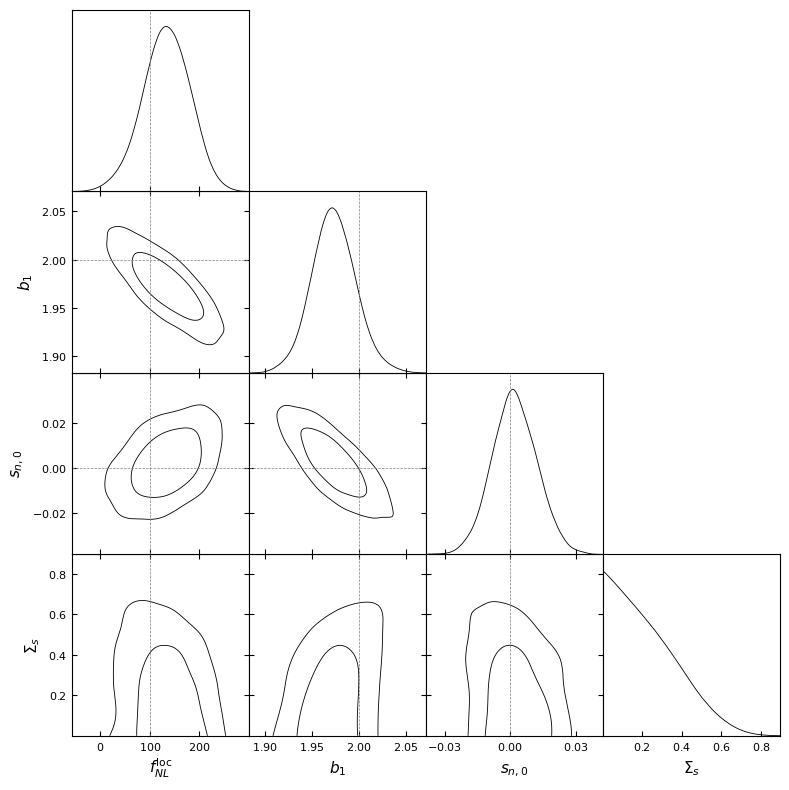

In [8]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'fnl_loc': 100., 'b1': b1, 'sn0': 0., 'sigmas': 0.})